In [293]:
import re
import random
import pandas as pd
import hashlib

In [294]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [295]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,42.894478,4.766053,9.033918,9
Email Auth and Security,209.599132,52.399783,76.162121,4
"Jane Eyre, Bronte",348.950167,43.618771,64.179093,8
Azure VM + Developer,365.425085,10.747797,20.711717,34
TSQL,674.260654,28.094194,37.712115,24
Azure AD Authentication,811.652579,67.637715,142.788355,12
RAG Project,853.117733,94.790859,245.009327,9
Logging in Python,961.721059,68.694361,112.105829,14
Azure Private DNS,1517.894051,79.889161,156.553913,19
C# Basics,2015.858237,65.027685,114.197600,31


# Histogram

sum of ages: ~48583.45


<Axes: >

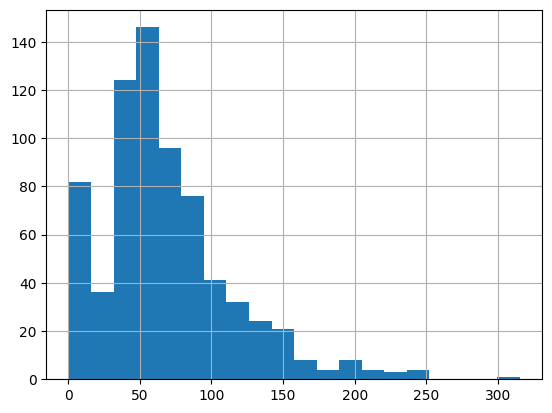

In [296]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~48583.45


<Axes: >

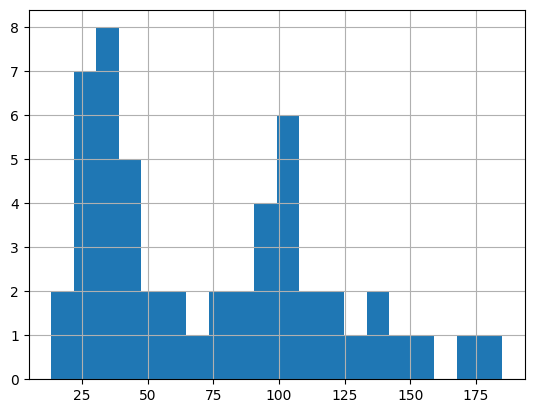

In [297]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [298]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [299]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [300]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [301]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [302]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [303]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [304]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [305]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 710
Total card age: 48583.45


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
14,Vocab,"Jingo, Pratchett\nFastidious\nadjective | fa-S...",de8c6a40b6b8d4491cae63532ded63d9,-150.020029,56.857387,150.020029,-4093.731863,0.635089,0,0
15,Vocab,"Well of Lost Plots, Fforde\nSpinney (of trees)...",8245a2187b440f0fd0991333e29b69e2,-116.732496,56.857387,150.020029,-4093.731863,0.635089,3,0
16,Vocab,Structured Credit Includes Products like CLOs ...,ba16c203dde80e3619a217a4d9f72260,-80.510550,56.857387,150.020029,-4093.731863,0.635089,6,0
499,Vocab,"Jingo, Pratchett\nVindaloo\nnoun | VIN-duh-loo...",715b75b46e9e2d81a07832ce1c79917b,-77.962384,56.857387,150.020029,-4093.731863,0.635089,9,0
502,Vocab,Structured Credit Carries Complexity and Risk:...,d1ddeb2102d877f18a1691442556fcdb,-69.860111,56.857387,150.020029,-4093.731863,0.635089,12,0
263,Vocab,"Well of Lost Plots, Fforde\nInveigle\nverb | i...",9fc881a68f1aa7c5604c358114142b61,-68.217405,56.857387,150.020029,-4093.731863,0.635089,15,0
20,Vocab,"Something Rotten, Fforde\nMuslin (curtains)\nn...",eb83088ac84321e16f95b700f58e4cf6,-63.111160,56.857387,150.020029,-4093.731863,0.635089,18,0
503,Vocab,"Well of Lost Plots, Fforde\nFoolscap\nnoun | F...",7bc3a1b3cf6c60a4a387d6fb342d8781,-61.739573,56.857387,150.020029,-4093.731863,0.635089,21,0
267,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-59.036633,56.857387,150.020029,-4093.731863,0.635089,24,0
505,Vocab,"Jingo, Pratchett\nRotas\nnoun (plural) | ROH-t...",2962ebeb526e550908aa4da49c684448,-57.972654,56.857387,150.020029,-4093.731863,0.635089,27,0


## Age Mean

In [306]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [307]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [308]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [309]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [310]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
192,C# Basics,.NET uses a garbage collector that automatical...,43bedaac447bb0b9a8a6f14b650981e4,-0.275632,65.027685,114.197600,-2015.858237,0.510053,30,0
547,JavaScript Concepts,JavaScript's array destructuring syntax is a c...,d1873d9f239196132e5ff5341adb3922,-1.510993,49.192013,243.170488,-3984.553085,0.170360,80,2
546,JavaScript Concepts,Callback\nA function passed as an argument to ...,9b3cd917f72d441abfeee7a79c32a076,-1.548598,49.192013,243.170488,-3984.553085,0.170360,79,1
545,JavaScript Concepts,If the addition operator + is used for primiti...,9cb500afa3eac8e680fbc3cd173ada6b,-1.938469,49.192013,243.170488,-3984.553085,0.170360,78,0
709,DAX,KEEPFILTERS vs. ALL/REMOVEFILTERS (and other m...,5d7a1a933dccd50da553422291e161c0,-2.171524,4.766053,9.033918,-42.894478,0.657476,8,2
308,JavaScript Concepts,Front: What are tagged templates and how do yo...,c01058319c7e76b3d1c1a0e23a0ab7af,-2.296644,49.192013,243.170488,-3984.553085,0.170360,77,2
477,DAX,KEEPFILTERS can outperform FILTER(...) for sim...,8cfd6c90079ed4e1ff7f47d8ee630ff9,-2.775564,4.766053,9.033918,-42.894478,0.657476,7,1
62,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,-2.836324,49.192013,243.170488,-3984.553085,0.170360,76,1
234,Azure VM + Developer,VS Code Workspace (.code-workspace)\nA VS Code...,d6d9a8f902e28c32abb08aeabaa29c4f,-3.031540,10.747797,20.711717,-365.425085,0.120724,33,0
708,DAX,KEEPFILTERS protects nested security or busine...,0cf299bbeeebf5bad5e600ad270acdbe,-3.112320,4.766053,9.033918,-42.894478,0.657476,6,0


In [311]:
existing_cards.head(10).sum()

head                   VocabVocabVocabVocabVocabVocabVocabVocabVocabV...
body                   Jingo, Pratchett\nFastidious\nadjective | fa-S...
hash                   de8c6a40b6b8d4491cae63532ded63d98245a2187b440f...
age                                                          -805.162994
subject_mean_age                                               568.57387
subject_highest_age                                          1500.200294
subject_age_sum                                            -40937.318625
head_random_roll                                                6.350891
count                                                                135
n_fold                                                                 0
dtype: object

In [312]:
existing_cards['age'].mean()

-68.42739825717891